In [1]:

import numpy as np
import pylab as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

import ahunt as ah

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
fname = 'mnist'
path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x0,y0,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x0 = x0/x0.max()

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958



In [75]:
ntry = 2
n_night = 10
n_questions = 0.5 # can be an integer or an array of numbers np.random.randint(3,7,n_night)
prefix = 'test1'

epochs = 5
noise = 0.1
check_c = True
nightly=False
givey = True
nmin_pre=None
save_latent = False

aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.04,
    height_shift_range=0.04,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.04,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")


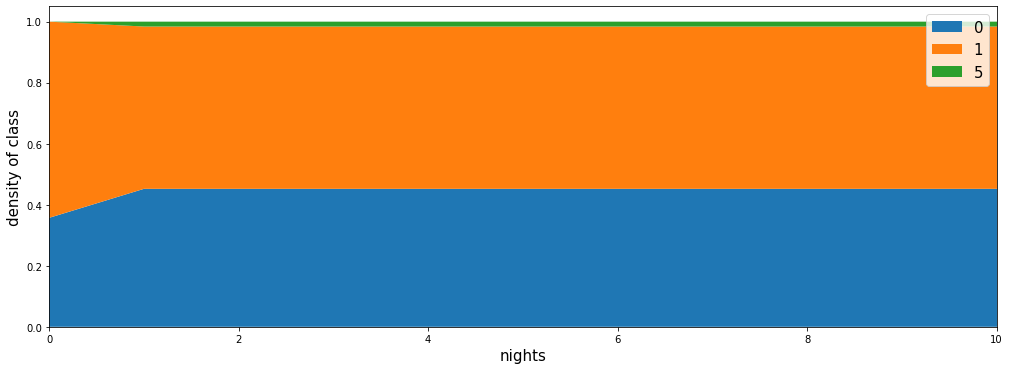

In [76]:
plan_totlier_ind = 5
pre_data_config = {0:500,1:900}
obs_plan = 30*[{0:170,1:200,outlier_ind:6}]#+10*[{0:170,1:200,outlier_ind:5,6:7}]+10*[{0:170,1:200,outlier_ind:4,7:20,8:100}]


# outlier_ind = lbl_mapper['bird']
# pre_data_config = {lbl_mapper['airplane']:400,lbl_mapper['automobile']:300}
# obs_plan = 30*[{lbl_mapper['airplane']:140,lbl_mapper['automobile']:150,outlier_ind:10}] #+ \


plan_tot = [pre_data_config]+obs_plan


fig,ax = plt.subplots(1,1,figsize=(14,5))
population_by_group = ah.plot_population(plan_tot,ax=ax)
ax.set_xlabel('nights',fontsize=15)
ax.set_ylabel('density of class',fontsize=15)
ax.set_xlim(0,n_night)
plt.legend(fontsize=15)
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
plt.savefig('config_{}.jpg'.format(prefix),dpi=150)

In [77]:
nmin,outlier_ind0,pre_data_config0,obs_plan0 = ah.planmaker(path,nmin_pre=nmin_pre,outlier_ind=outlier_ind)
n_questions0 = int(0.7*nmin)

if n_questions is None: n_questions=n_questions0
if outlier_ind is None: outlier_ind=outlier_ind0
if pre_data_config is None: pre_data_config=pre_data_config0
if obs_plan is None: obs_plan=obs_plan0
print(pre_data_config)
print(obs_plan[0])

if type(n_questions) is int or type(n_questions) is float:
    if n_questions==1 and type(n_questions) is float:
        assert 0,'Warning, when you choose 1, it should be integer.'
    n_questions = n_night*[n_questions]

if x0.ndim==3:
    n_tot,lx,ly = x0.shape
#     x = x.reshape(n_tot,lx*ly)
    x0 = x0[:,:,:,None]
    nch = 1
elif x0.ndim==4:
    n_tot,lx,ly,nch = x0.shape

if noise!=0:
    x0 += np.random.normal(0,noise,x0.shape)
n_class,class_labels, nums = ah.describe_labels(y0,verbose=0)

outlier is  class5
{0: 500, 1: 900}
{0: 170, 1: 200, 5: 6}


In [3]:
res_all = []
res5 = []

for nt in range(ntry):
    res1 = []
    res2 = []
    res3 = []
    res4 = []
    # if save_latent:
    z_mus = []
    lbls = []
    nq_all = []
    
    x,y = ah.shuffle_data(x0,y0)
    # data 0
    x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
    # observation
    obs = ah.Observetory(obs_plan,x,y)

    y = y_pre if givey else None

    ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt.fit(epochs=epochs)

    ahunt0 = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt0.fit(epochs=epochs)

    if n_night is None: n_night = obs.n_plan

    phc = ah.PredictionHistoryChecker()

    for night in range(n_night):
        print('try:{}, night:{}'.format(nt,night),end='\r')
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        out_obs = y_obs==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        ano_inds = np.argwhere(out_obs)[:,0]

        # Method 1
        scr_ano = ah.iforest_get_anomalies(x_obs.reshape(-1,lx*ly*nch))
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh

        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res1.append([rws,rc,pr,mcc,true_guess])

        # Method 2
        z_mu = ahunt0.to_latent(x_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res2.append([rws,rc,pr,mcc,true_guess])

        # Method 3
        z_mu = ahunt.to_latent(x_obs)
        if save_latent:
            z_mus.append(z_mu)
            lbls.append(y_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)

        true_guess = phc.get_tguess(n_questions[night],scr_ano,ano_inds,x_obs)
        res3.append([rws,rc,pr,mcc,true_guess])

        # Method 4
        true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])
        nq_all.append(len(ahunt.inds_all))

        ahunt.fit(epochs=epochs)
    #     model_par.append(stds_model(ahunt.clf))
        scr_ano = ahunt.predict(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        res4.append([rws,rc,pr,mcc,true_guess])

    res1 = np.array(res1)
    res2 = np.array(res2)
    res3 = np.array(res3)
    res4 = np.array(res4)
    
    nq_all = np.array(nq_all)
    res1[:,4] = 100*res1[:,4]/np.array(nq_all)
    res2[:,4] = 100*res2[:,4]/np.array(nq_all)
    res3[:,4] = 100*res3[:,4]/np.array(nq_all)
    res4[:,4] = 100*res4[:,4]/np.array(nq_all)
    
    res1[:,4] = np.nan_to_num(res1[:,4])
    res2[:,4] = np.nan_to_num(res2[:,4])
    res3[:,4] = np.nan_to_num(res3[:,4])
    res4[:,4] = np.nan_to_num(res4[:,4])

    res_all.append([res1,res2,res3,res4])
    
    if check_c and not nightly:

        xc = np.concatenate([x_pre,x_obs],axis=0)
        yc = np.concatenate([y_pre,y_obs],axis=0)
        
        ahunt = ah.AHunt(xc, y=yc, interest=None, aug=aug)
        true_guess = ahunt.human_call(xc,yc,np.sum(nq_all))
        ahunt.fit(epochs=n_night*epochs,verbose=0)
        
        out_obs = yc==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        
        scr_ano = ahunt.predict(xc)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
    res5.append([rws,rc,pr,mcc,true_guess])

res5 = np.array(res5)
np.save('{}{}_res'.format(prefix,fname),res_all)
np.save('{}{}_res5'.format(prefix,fname),res5)

In [33]:
res_all = np.load('{}{}_res.npy'.format(prefix,fname))
res5 = np.load('{}{}_res5.npy'.format(prefix,fname))
n_night = res_all.shape[2]
# metrics_all = np.array([i[:-2] for i in res_all])

alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,10))

lbls = 'iforest_raw','iforest_latent-static','iforest_latent-learning','AHunt'
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(4):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], clr=clrs[i], label=lbls[i], alpha=alpha)
        
    m5 = np.mean(res5[:,jj])
    ax.plot(np.arange(n_night),n_night*[m5],'k--',label='classifier')
    
    ax.set_xlabel('night',fontsize=15)
    ax.set_ylabel(metric_names[j],fontsize=15)
    ax.set_xlim(0,n_night-1)
    if jj==4:
        ax.set_ylim(0,102)
    else:
        ax.set_ylim(0,1.05)
    
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.06, right=0.99, top=0.99, wspace=None, hspace=None)
plt.savefig('result_{}.jpg'.format(prefix),dpi=150)